# H₃⁺ Mapping Comparison — JW vs BK vs Parity

This notebook compares fermion-to-qubit mappings for the H₃⁺ molecule
using noiseless VQE with a fixed UCCSD ansatz.

We vary only the mapping:
- Jordan–Wigner
- Bravyi–Kitaev
- Parity

All other ingredients (geometry, electrons, ansatz, optimizer)
remain constant.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import sys, os, json, time

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from vqe.vqe_utils import (
    IMG_DIR,
    excitation_ansatz,
    get_optimizer,
    set_seed,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    ensure_dirs,
    build_run_filename,
)

ensure_dirs()

In [2]:
# Reproducibility
seed = 0
set_seed(seed)

# Distorted H₃⁺ geometry (Å)
symbols = ["H", "H", "H"]
coordinates = np.array([
    [ 0.0,      1.0,     0.0],
    [-0.866025, -0.5,    0.0],
    [ 0.800000, -0.3,    0.0],
])
basis = "STO-3G"
electrons = 2
charge = +1

mappings = ["jordan_wigner", "bravyi_kitaev", "parity"]

In [3]:
# Build qubit Hamiltonians per mapping
hamiltonians = {}
qubits_required = {}
pauli_terms = {}

for mapping in mappings:
    H, n_qubits = qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        charge=charge,
        basis=basis,
        mapping=mapping,
        active_electrons=electrons,
    )
    hamiltonians[mapping] = H
    qubits_required[mapping] = n_qubits
    pauli_terms[mapping] = len(H)
    print(f"{mapping:>15}: {len(H)} Pauli terms, {n_qubits} qubits")

  jordan_wigner: 118 Pauli terms, 6 qubits
  bravyi_kitaev: 118 Pauli terms, 6 qubits
         parity: 118 Pauli terms, 6 qubits


In [4]:
# UCCSD ingredients
qubits = qubits_required["jordan_wigner"]
hf_state = qchem.hf_state(electrons, qubits)

singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(s) for s in singles]
doubles = [tuple(d) for d in doubles]

print(f"HF state |{''.join(str(b) for b in hf_state)}⟩")
print(f"Singles: {len(singles)}, Doubles: {len(doubles)}")

HF state |110000⟩
Singles: 4, Doubles: 4


In [5]:
# Cache-aware VQE per mapping
def run_mapping_with_cache(mapping, stepsize=0.2, max_iter=50):
    H = hamiltonians[mapping]
    n_qubits = qubits_required[mapping]

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev)
    def cost_fn(params):
        excitation_ansatz(
            params,
            wires=range(n_qubits),
            hf_state=hf_state,
            excitations=(singles, doubles),
            excitation_type="both",
        )
        return qml.expval(H)

    optimizer_name = "Adam"
    ansatz_desc = f"UCCSD (mapping={mapping})"

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iter,
        seed=seed,
    )
    cfg["mapping"] = mapping

    sig = run_signature(cfg)
    fname = build_run_filename(f"H3plus_Mapping_{mapping}", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {mapping}: {existing}")
        return rec["energies"]

    params = np.zeros(len(singles) + len(doubles), requires_grad=True)
    opt = get_optimizer(optimizer_name, stepsize=stepsize)

    energies = [float(cost_fn(params))]
    for _ in range(max_iter):
        params, e_prev = opt.step_and_cost(cost_fn, params)
        energies.append(float(e_prev))

    energies[-1] = float(cost_fn(params))

    rec = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H3plus",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "electrons": electrons,
        "num_wires": n_qubits,
        "mapping": mapping,
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": optimizer_name,
            "stepsize": stepsize,
            "iterations_planned": max_iter,
            "iterations_ran": len(energies) - 1,
        },
        "seed": seed,
        "energies": energies,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
        "metadata": {"pauli_terms": pauli_terms[mapping]},
    }

    save_run_record(fname, rec)
    print(f"[saved] {mapping}: {fname}")
    return energies

In [6]:
# Run / load results
results = {}
for mapping in mappings:
    print(f"\n> Running mapping = {mapping}")
    results[mapping] = run_mapping_with_cache(mapping, stepsize=0.2, max_iter=50)


> Running mapping = jordan_wigner
[saved] jordan_wigner: H3plus_Mapping_jordan_wigner_Adam_s0__bf6390d6c44d

> Running mapping = bravyi_kitaev
[saved] bravyi_kitaev: H3plus_Mapping_bravyi_kitaev_Adam_s0__01928c44d93b

> Running mapping = parity
[saved] parity: H3plus_Mapping_parity_Adam_s0__ac9ac4ecc97a


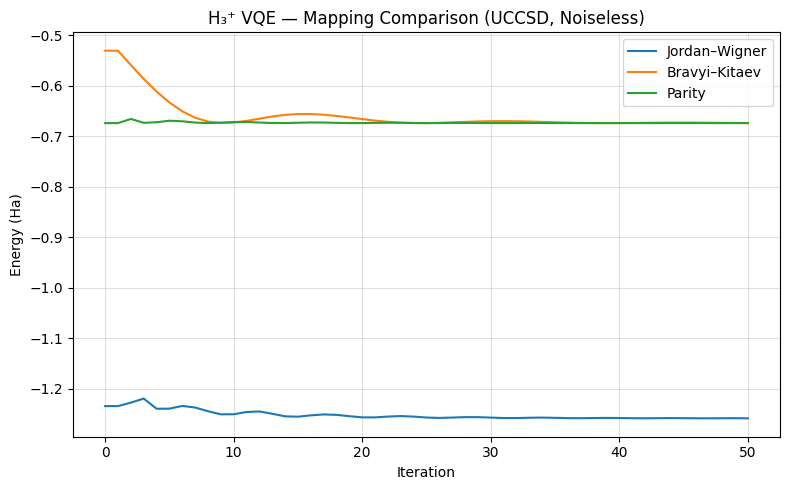

In [7]:
# Plot convergence
label_map = {
    "jordan_wigner": "Jordan–Wigner",
    "bravyi_kitaev": "Bravyi–Kitaev",
    "parity": "Parity",
}

plt.figure(figsize=(8, 5))
for mapping in mappings:
    plt.plot(results[mapping], label=label_map[mapping])

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ VQE — Mapping Comparison (UCCSD, Noiseless)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()

out = os.path.join(IMG_DIR, "H3plus_Mapping_Comparison.png")
plt.savefig(out, dpi=300)
plt.show()

In [8]:
# Final comparison summary
print("\nFinal energies:")
final_E = {}
for mapping in mappings:
    E = results[mapping][-1]
    final_E[mapping] = E
    print(f"{mapping:>15}: {E:.8f} Ha  ({pauli_terms[mapping]} Pauli terms)")

best = min(final_E, key=final_E.get)
print(f"\nBest mapping: {best}   E = {final_E[best]:.8f} Ha")


Final energies:
  jordan_wigner: -1.25867803 Ha  (118 Pauli terms)
  bravyi_kitaev: -0.67410221 Ha  (118 Pauli terms)
         parity: -0.67413491 Ha  (118 Pauli terms)

Best mapping: jordan_wigner   E = -1.25867803 Ha
